In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import keras

In [29]:
df = pd.read_csv('./archiveweather/GlobalLandTemperaturesByCountry.csv', parse_dates=['dt'], index_col='dt')
df = df[df['Country'] == 'Poland']
df = df[df.index > '1900-12-31']
df = df.drop('Country', axis = 1)

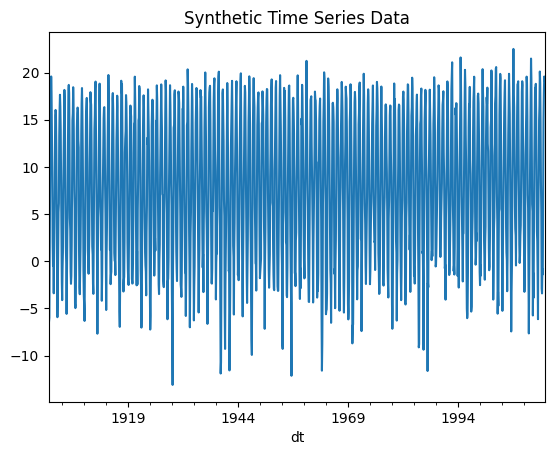

In [30]:
def show_raw_visualization(data):
    time_series = df['AverageTemperature']
    # Plotting the data
    time_series.plot()
    plt.title('Synthetic Time Series Data')
    plt.show()

show_raw_visualization(df)

In [31]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 120
future = 24
learning_rate = 0.001
batch_size = 64
epochs = 10


def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [11]:
train_data = df.iloc[0:1080]
test_data = df.iloc[1080:]

In [32]:
import numpy as np 

# Calculate start and end indices for the training data
start = past + future
end = start + train_split

# Define your variables (past, future, train_split, step, batch_size)

# Extract x_train and y_train from the DataFrame
x_train = df.iloc[:train_split, :past].values  # Assuming the first 'past' columns are the input features
y_train = df.iloc[start:end, -1].values  # Assuming the last column is the target variable

# Convert x_train and y_train to a compatible data type (e.g., float32)
x_train = x_train.astype(np.float32)
y_train = y_train.astype(np.float32)

# Define the sequence length
sequence_length = int(past / step)

# Create the time series dataset
dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,  # Use the entire x_train array
    y_train,  # Use the y_train array
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

# Verify the types of x_train and y_train
print(type(x_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [43]:
# Preprocessing the Data
df = df[['AverageTemperature']].dropna()  # Dropping rows with missing values

# # Normalizing the data
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler(feature_range=(0, 1))
# df_scaled = scaler.fit_transform(df)

# Creating a dataset for training LSTM model
import numpy as np

def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset.iloc[i:(i + look_back)].values  # Using .iloc and .values for proper slicing
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 3  # number of previous time steps to consider
X, y = create_dataset(df, look_back)

# Splitting data into training and validation sets
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
trainX, testX = X[0:train_size], X[train_size:len(X)]
trainY, testY = y[0:train_size], y[train_size:len(y)]

In [45]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Build the LSTM model
model = Sequential()
model.add(LSTM(50, input_shape=(look_back, 1)))
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=64, verbose=2, validation_data=(testX, testY))

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
from sklearn.metrics import mean_squared_error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Epoch 1/100
15/15 - 1s - loss: 122.1291 - val_loss: 120.8704 - 1s/epoch - 74ms/step
Epoch 2/100
15/15 - 0s - loss: 107.1473 - val_loss: 105.8079 - 36ms/epoch - 2ms/step
Epoch 3/100
15/15 - 0s - loss: 94.0390 - val_loss: 92.3226 - 35ms/epoch - 2ms/step
Epoch 4/100
15/15 - 0s - loss: 82.3118 - val_loss: 80.4797 - 36ms/epoch - 2ms/step
Epoch 5/100
15/15 - 0s - loss: 71.5722 - val_loss: 69.6195 - 37ms/epoch - 2ms/step
Epoch 6/100
15/15 - 0s - loss: 61.8469 - val_loss: 60.3933 - 36ms/epoch - 2ms/step
Epoch 7/100
15/15 - 0s - loss: 53.5910 - val_loss: 52.3430 - 36ms/epoch - 2ms/step
Epoch 8/100
15/15 - 0s - loss: 45.9681 - val_loss: 44.9844 - 35ms/epoch - 2ms/step
Epoch 9/100
15/15 - 0s - loss: 39.0896 - val_loss: 38.3006 - 35ms/epoch - 2ms/step
Epoch 10/100
15/15 - 0s - loss: 33.3342 - val_loss: 33.3751 - 35ms/epoch - 2ms/step
Epoch 11/100
15/15 - 0s - loss: 28.8562 - val_loss: 29.4255 - 35ms/epoch - 2ms/step
Epoch 12/100
15/15 - 0s - loss: 25.3452 - val_loss: 26.2150 - 35ms/epoch - 2ms/ste

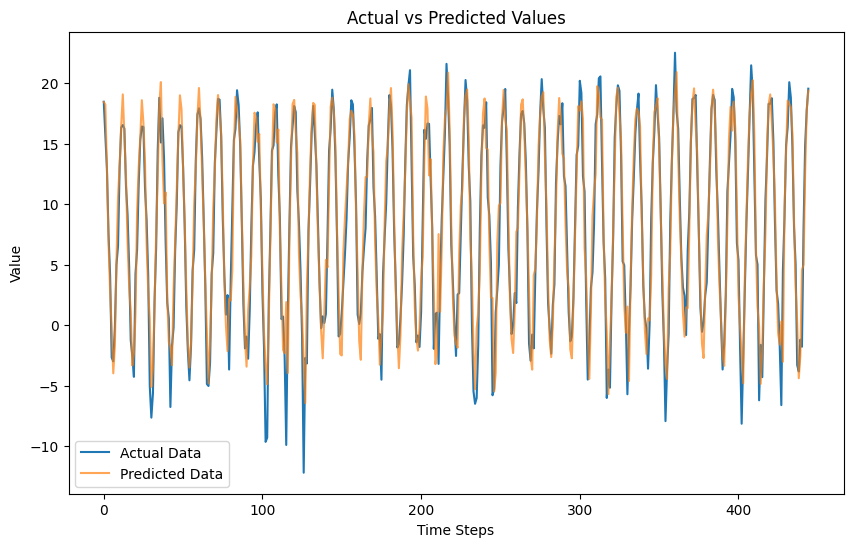

In [41]:
import matplotlib.pyplot as plt

# Inverting the scaling for actual values
actual = scaler.inverse_transform([testY[0]])
actual = actual/35
# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(actual[0], label='Actual Data')
plt.plot(testPredict[:,0], label='Predicted Data', alpha=0.7)
plt.title('Actual vs Predicted Values')
plt.xlabel('Time Steps')
plt.ylabel('Value')
plt.legend()
plt.show()